In [1]:
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
Global seed set to 0


# Loading Visium and scRNA-seq reference data

In [55]:
wk_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
data_root = os.path.join(wk_root, "result/cci/MB/raw_data/")

adata_vis = sc.read(os.path.join(data_root, 'Mouse_Brain_Bin200.h5ad'))
adata_vis

AnnData object with n_obs × n_vars = 5420 × 27279
    obs: 'array_row', 'array_col'
    obsm: 'spatial'
    layers: 'count'

In [2]:
results_folder = os.path.join(wk_root, 'result/cci/MB/c2l_results/mouse_brain_bin200/')

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

In [56]:
adata_vis.var_names

Index(['0610010F05Rik', '0610012G03Rik', '0610043K17Rik', '1110008F13Rik',
       '1110008P14Rik', '1110019D14Rik', '1110065P20Rik', '1190002N15Rik',
       '1500009L16Rik', '1500011B03Rik',
       ...
       'Gm10612', 'Gm41144', 'Olfr631', 'Trbv13-2', 'Gm33847', 'Gm29520',
       'Olfr857', 'Gm10509', 'Gm32063', 'Gm37756'],
      dtype='object', name='gene_short_name', length=27279)

In [57]:
adata_vis.var['SYMBOL'] = adata_vis.var_names
adata_vis.obs['sample'] = 'Mouse_Brain_Bin200'

In [58]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]
adata_vis

View of AnnData object with n_obs × n_vars = 5420 × 27279
    obs: 'array_row', 'array_col', 'sample'
    var: 'SYMBOL', 'MT_gene'
    obsm: 'spatial', 'MT'
    layers: 'count'

In [7]:
sc_data_folder = os.path.join(wk_root, "result/cci/MB/anno_data/")

In [8]:
adata_ref = sc.read_h5ad(sc_data_folder + "all_cells_20200625.h5ad")

In [9]:
adata_ref

AnnData object with n_obs × n_vars = 40572 × 31053
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sample', 'barcode'
    var: 'feature_types', 'genome', 'SYMBOL', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt'

In [10]:
adata_ref.var_names

Index(['ENSMUSG00000051951', 'ENSMUSG00000089699', 'ENSMUSG00000102343',
       'ENSMUSG00000025900', 'ENSMUSG00000025902', 'ENSMUSG00000104328',
       'ENSMUSG00000033845', 'ENSMUSG00000025903', 'ENSMUSG00000104217',
       'ENSMUSG00000033813',
       ...
       'ENSMUSG00000079192', 'ENSMUSG00000079794', 'ENSMUSG00000094799',
       'ENSMUSG00000095019', 'ENSMUSG00000094915', 'ENSMUSG00000079808',
       'ENSMUSG00000095041', 'ENSMUSG00000063897', 'ENSMUSG00000096730',
       'ENSMUSG00000095742'],
      dtype='object', name='ENSEMBL', length=31053)

In [11]:
adata_ref.obs_names

Index(['5705STDY8058283_AAACCCAAGCCTATTG-1',
       '5705STDY8058283_AAACCCAAGGTCATAA-1',
       '5705STDY8058283_AAACCCACAACCCTCT-1',
       '5705STDY8058283_AAACCCAGTGCTATTG-1',
       '5705STDY8058283_AAACCCAGTTCACCGG-1',
       '5705STDY8058283_AAACGAAAGGTAGACC-1',
       '5705STDY8058283_AAACGAACACGACGCT-1',
       '5705STDY8058283_AAACGAAGTATCACGT-1',
       '5705STDY8058283_AAACGAAGTGGCCCAT-1',
       '5705STDY8058283_AAACGAAGTGGCGCTT-1',
       ...
       '5705STDY8058280_TTTGTTGAGTTTCAGC-1',
       '5705STDY8058280_TTTGTTGCAACAAGAT-1',
       '5705STDY8058280_TTTGTTGCAATCTCTT-1',
       '5705STDY8058280_TTTGTTGCACCCTCTA-1',
       '5705STDY8058280_TTTGTTGCACTGGCCA-1',
       '5705STDY8058280_TTTGTTGCAGAGTGAC-1',
       '5705STDY8058280_TTTGTTGCATCGCTCT-1',
       '5705STDY8058280_TTTGTTGGTATGGTAA-1',
       '5705STDY8058280_TTTGTTGGTGTAGTGG-1',
       '5705STDY8058280_TTTGTTGGTTAGGCCC-1'],
      dtype='object', length=40572)

In [12]:
labels = pd.read_csv(sc_data_folder + 'snRNA_annotation_astro_subtypes_refined59_20200823.csv', index_col=0)
labels

annotation_1
5705STDY8058283_AAACCCAAGCCTATTG-1         Ext_L23
5705STDY8058283_AAACCCAAGGTCATAA-1         Oligo_2
5705STDY8058283_AAACCCACAACCCTCT-1         Oligo_2
5705STDY8058283_AAACCCAGTGCTATTG-1  Astro_THAL_med
5705STDY8058283_AAACCCAGTTCACCGG-1         Inh_Sst
...                                            ...
5705STDY8058280_TTTGTTGCAGAGTGAC-1           Micro
5705STDY8058280_TTTGTTGCATCGCTCT-1         Oligo_2
5705STDY8058280_TTTGTTGGTATGGTAA-1     Inh_Meis2_3
5705STDY8058280_TTTGTTGGTGTAGTGG-1         Oligo_2
5705STDY8058280_TTTGTTGGTTAGGCCC-1          LowQ_2

[40532 rows x 1 columns]

In [13]:
labels = labels.reindex(index=adata_ref.obs_names)
labels

annotation_1
5705STDY8058283_AAACCCAAGCCTATTG-1         Ext_L23
5705STDY8058283_AAACCCAAGGTCATAA-1         Oligo_2
5705STDY8058283_AAACCCACAACCCTCT-1         Oligo_2
5705STDY8058283_AAACCCAGTGCTATTG-1  Astro_THAL_med
5705STDY8058283_AAACCCAGTTCACCGG-1         Inh_Sst
...                                            ...
5705STDY8058280_TTTGTTGCAGAGTGAC-1           Micro
5705STDY8058280_TTTGTTGCATCGCTCT-1         Oligo_2
5705STDY8058280_TTTGTTGGTATGGTAA-1     Inh_Meis2_3
5705STDY8058280_TTTGTTGGTGTAGTGG-1         Oligo_2
5705STDY8058280_TTTGTTGGTTAGGCCC-1          LowQ_2

[40572 rows x 1 columns]

In [14]:
adata_ref.obs['annotation'] = labels
adata_ref = adata_ref[~adata_ref.obs['annotation'].isna(), :]
adata_ref

View of AnnData object with n_obs × n_vars = 40532 × 31053
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sample', 'barcode', 'annotation'
    var: 'feature_types', 'genome', 'SYMBOL', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt'

/media/bgi/liukeyin/.conda/envs/cell2location_env/lib/python3.9/site-packages/cell2location/utils/filtering.py:26: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.


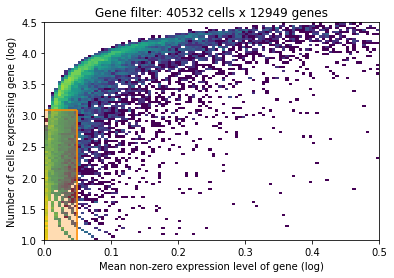

AnnData object with n_obs × n_vars = 40532 × 12949
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sample', 'barcode', 'annotation'
    var: 'feature_types', 'genome', 'SYMBOL', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'n_cells', 'nonz_mean'

In [15]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()
adata_ref

<AxesSubplot:xlabel='n_cells'>

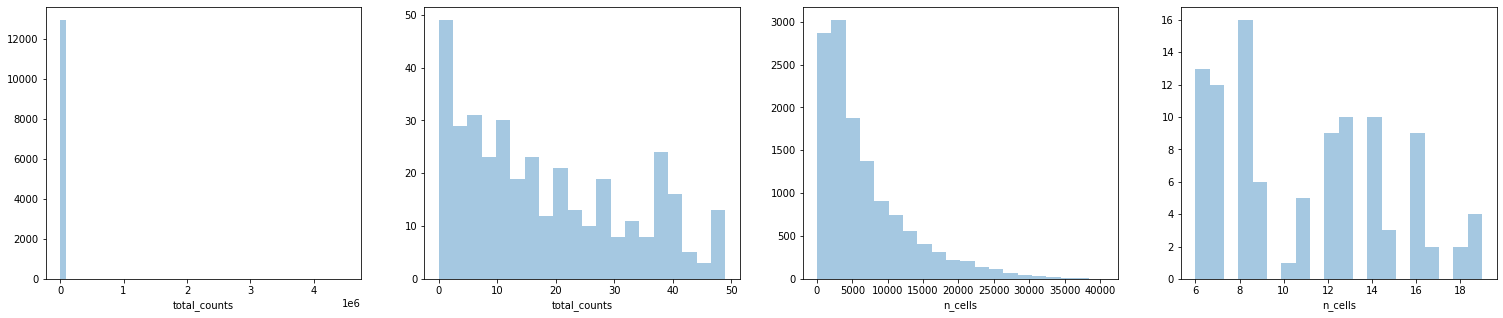

In [18]:
fig, axs = plt.subplots(1, 4, figsize=(26, 5))
sns.distplot(adata_ref.var["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata_ref.var["total_counts"][adata_ref.var["total_counts"] < 50], kde=False, bins=20, ax=axs[1])
sns.distplot(adata_ref.var["n_cells"], kde=False, bins=20, ax=axs[2])
sns.distplot(adata_ref.var["n_cells"][adata_ref.var["n_cells"] < 20], kde=False, bins=20, ax=axs[3])

In [19]:
adata_ref.var

feature_types              genome          SYMBOL  \
ENSEMBL                                                                   
ENSMUSG00000051951  Gene Expression  mm10-3.0.0_premrna            Xkr4   
ENSMUSG00000089699  Gene Expression  mm10-3.0.0_premrna          Gm1992   
ENSMUSG00000025902  Gene Expression  mm10-3.0.0_premrna           Sox17   
ENSMUSG00000033845  Gene Expression  mm10-3.0.0_premrna          Mrpl15   
ENSMUSG00000033813  Gene Expression  mm10-3.0.0_premrna           Tcea1   
...                             ...                 ...             ...   
ENSMUSG00000064370  Gene Expression  mm10-3.0.0_premrna         mt-Cytb   
ENSMUSG00000051412  Gene Expression  mm10-3.0.0_premrna           Vamp7   
ENSMUSG00000079834  Gene Expression  mm10-3.0.0_premrna           Tmlhe   
ENSMUSG00000095041  Gene Expression  mm10-3.0.0_premrna      AC149090.1   
ENSMUSG00000063897  Gene Expression  mm10-3.0.0_premrna  CAAA01118383.1   

                    n_cells_by_counts   mean_counts  log1p_mean_counts  \
ENSEMBL                                                                  
ENSMUSG00000051951               6618  6.008789e-03       5.990808e-03   
ENSMUSG00000089699               2974  1.003844e-03       1.003341e-03   
ENSMUSG00000025902                  1  1.471696e-07       1.471696e-07   
ENSMUSG00000033845               2722  4.335617e-04       4.334678e-04   
ENSMUSG00000033813               1617  2.734412e-04       2.734038e-04   
...                               ...           ...                ...   
ENSMUSG00000064370               3843  7.618972e-04       7.616071e-04   
ENSMUSG00000051412               1490  2.338526e-04       2.338252e-04   
ENSMUSG00000079834               1959  3.925014e-04       3.924244e-04   
ENSMUSG00000095041               3513  1.081550e-03       1.080965e-03   
ENSMUSG00000063897                841  1.334829e-04       1.334739e-04   

                    pct_dropout_by_counts  total_counts  log1p_total_counts  \
ENSEMBL                                                                       
ENSMUSG00000051951              99.902603       40829.0           10.617172   
ENSMUSG00000089699              99.956232        6821.0            8.827908   
ENSMUSG00000025902              99.999985           1.0            0.693147   
ENSMUSG00000033845              99.959940        2946.0            7.988543   
ENSMUSG00000033813              99.976203        1858.0            7.527794   
...                                   ...           ...                 ...   
ENSMUSG00000064370              99.943443        5177.0            8.552175   
ENSMUSG00000051412              99.978072        1589.0            7.371490   
ENSMUSG00000079834              99.971169        2667.0            7.889084   
ENSMUSG00000095041              99.948299        7349.0            8.902455   
ENSMUSG00000063897              99.987623         907.0            6.811244   

                       mt  n_cells  nonz_mean  
ENSEMBL                                        
ENSMUSG00000051951  False    29115   7.531479  
ENSMUSG00000089699  False    16809   2.321613  
ENSMUSG00000025902  False       14   1.285714  
ENSMUSG00000033845  False     5392   1.138168  
ENSMUSG00000033813  False     6021   1.151636  
...                   ...      ...        ...  
ENSMUSG00000064370   True     6340   1.359306  
ENSMUSG00000051412  False     3175   1.078425  
ENSMUSG00000079834  False     9246   1.302509  
ENSMUSG00000095041  False    18506   2.350373  
ENSMUSG00000063897  False     2815   1.087034  

[12949 rows x 12 columns]

# Estimation of reference cell type signatures (NB regression)

In [20]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key='sample',
                        # cell type, covariate used for constructing signatures
                        labels_key='annotation',
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
#                         categorical_covariate_keys=['Method']
                       )

In [21]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.1.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': 'annotation',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_cells          │ 40532 │
│          n_vars          │ 12949 │
│         n_batch          │   6   │
│         n_labels         │  59   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃   Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ 5705STDY8058280 │          0          │
│                     │ 5705STDY8058281 │          1          │
│                     │ 5705STDY8058282 │          2          │
│                     │ 5705STDY8058283 │          3          │
│                     │ 5705STDY8058284 │          4          │
│                     │ 5705STDY8058285 │          5          │
└─────────────────────┴─────────────────┴─────────────────────┘

                      labels State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃   Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['annotation'] │   Astro_AMY    │          0          │
│                         │ Astro_AMY_CTX  │          1          │
│                         │   Astro_CTX    │          2          │
│                         │   Astro_HPC    │          3          │
│                         │   Astro_HYPO   │          4          │
│                         │   Astro_STR    │          5          │
│                         │ Astro_THAL_hab │          6          │
│                         │ Astro_THAL_lat │          7          │
│                         │ Astro_THAL_med │          8          │
│                         │    Astro_WM    │          9          │
│                         │      Endo      │         10          │
│                         │   Ext_Amy_1    │         11          │
│                         │   Ext_Amy_2    │         12          │
│                         │  Ext_ClauPyr   │         13          │
│                         │  Ext_Hpc_CA1   │         14          │
│                         │  Ext_Hpc_CA2   │         15          │
│                         │  Ext_Hpc_CA3   │         16          │
│                         │  Ext_Hpc_DG1   │         17          │
│                         │  Ext_Hpc_DG2   │         18          │
│                         │    Ext_L23     │         19          │
│                         │    Ext_L25     │         20          │
│                         │    Ext_L56     │         21          │
│                         │    Ext_L5_1    │         22          │
│                         │    Ext_L5_2    │         23          │
│                         │    Ext_L5_3    │         24          │
│                         │     Ext_L6     │         25          │
│                         │    Ext_L6B     │         26          │
│                         │    Ext_Med     │         27          │
│                         │    Ext_Pir     │         28          │
│                         │   Ext_Thal_1   │         29          │
│                         │   Ext_Thal_2   │         30          │
│                         │   Ext_Unk_1    │         31          │
│                         │   Ext_Unk_2    │         32          │
│                         │   Ext_Unk_3    │         33          │
│                         │     Inh_1      │         34          │
│                         │     Inh_2      │         35          │
│                         │     Inh_3      │         36          │
│                         │     Inh_4      │         37          │
│                         │     Inh_5      │         38          │
│                         │     Inh_6      │         39          │
│                         │   Inh_Lamp5    │         40          │
│                         │  Inh_Meis2_1   │         41          │
│                         │  Inh_Meis2_2   │         42          │
│                         │  Inh_Meis2_3   │         43          │
│                         │  Inh_Meis2_4   │         44          │
│                         │   Inh_Pvalb    │         45          │
│                         │    Inh_Sst     │         46          │
│                         │    Inh_Vip     │         47          │
│                         │     LowQ_1     │         48          │
│                         │     LowQ_2     │         49          │
│                         │     Micro      │         50          │
│                         │      Nb_1      │         51          │
│                         │      Nb_2      │         52          │
│                         │     OPC_1      │         53          │
│                         │     OPC_2      │         54          │
│                         │    Oligo_1     │   

In [22]:
mod.train(max_epochs=250, use_gpu=True)


# train(max_epochs: Optional[int] = None, batch_size: int = 2500, train_size: float = 1, lr: float = 0.002, **kwargs)

# max_epochs – Number of passes through the dataset. If None, defaults to np.min([round((20000 / n_cells) * 400), 400])
# train_size – Size of training set in the range [0.0, 1.0].
# batch_size – Minibatch size to use during training. If None, no minibatching occurs and all data is copied to device (e.g., GPU).
# lr – Optimiser learning rate (default optimiser is ClippedAdam). Specifying optimiser via plan_kwargs overrides this choice of lr.
# kwargs – Other arguments to scvi.model.base.PyroSviTrainMixin().train() method

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/media/bgi/liukeyin/.conda/envs/cell2location_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 250/250: 100%|████████████████████████████████████████| 250/250 [20:58<00:00,  5.04s/it, v_num=1, elbo_train=2.53e+8]


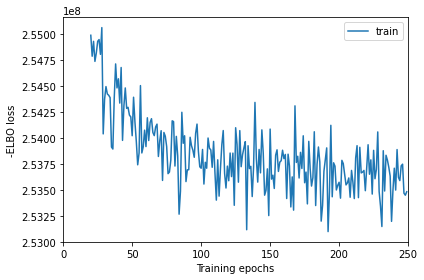

In [23]:
mod.plot_history(20)

In [24]:
adata_ref

AnnData object with n_obs × n_vars = 40532 × 12949
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sample', 'barcode', 'annotation', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'genome', 'SYMBOL', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'n_cells', 'nonz_mean'
    uns: '_scvi_uuid', '_scvi_manager_uuid'

In [25]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc_mouse_brain.h5ad"
adata_ref.write(adata_file)
adata_file

Sampling global variables, sample: 100%|█████████████████████████████████████████████████| 999/999 [00:15<00:00, 65.15it/s]


'./c2l_results/mouse_brain_bin200//reference_signatures/sc_mouse_brain.h5ad'

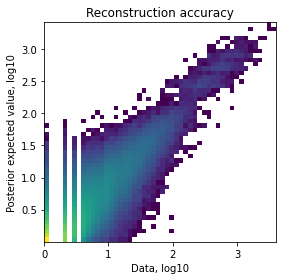

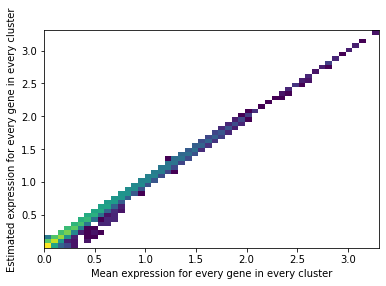

In [26]:
# Examine QC plots.

# Reconstruction accuracy to assess if there are any issues with inference. 
# This 2D histogram plot should have most observations along a noisy diagonal.

# The estimated expression signatures are distinct from mean expression in each cluster because of batch effects. 
# For scRNA-seq datasets which do not suffer from batch effect (this dataset does), 
# cluster average expression can be used instead of estimating signatures with a model. 
# When this plot is very different from a diagonal plot (e.g. very low values on Y-axis, 
# density everywhere) it indicates problems with signature estimation.
mod.plot_QC()

In [ ]:
## reload

# adata_file = f"{ref_run_name}/sc_mouse_brain.h5ad"
# adata_ref = sc.read_h5ad(adata_file)
# mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

In [51]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

Astro_AMY  Astro_AMY_CTX  Astro_CTX  Astro_HPC  Astro_HYPO
ENSEMBL                                                                       
ENSMUSG00000051951   0.042450       0.081058   0.059062   0.062989    0.088193
ENSMUSG00000089699   0.004975       0.007515   0.009471   0.007777    0.016451
ENSMUSG00000025902   0.001997       0.003871   0.002744   0.004197    0.002494
ENSMUSG00000033845   0.116829       0.056490   0.098002   0.067916    0.083110
ENSMUSG00000033813   0.095655       0.105883   0.142822   0.099135    0.095910

In [52]:
inf_aver.index = adata_ref.var['SYMBOL']

In [53]:
inf_aver

Astro_AMY  Astro_AMY_CTX  Astro_CTX  Astro_HPC  Astro_HYPO  \
SYMBOL                                                                       
Xkr4             0.042450       0.081058   0.059062   0.062989    0.088193   
Gm1992           0.004975       0.007515   0.009471   0.007777    0.016451   
Sox17            0.001997       0.003871   0.002744   0.004197    0.002494   
Mrpl15           0.116829       0.056490   0.098002   0.067916    0.083110   
Tcea1            0.095655       0.105883   0.142822   0.099135    0.095910   
...                   ...            ...        ...        ...         ...   
mt-Cytb          0.155936       0.128288   0.101156   0.121246    0.068081   
Vamp7            0.042524       0.041987   0.050194   0.056718    0.043149   
Tmlhe            0.249433       0.268129   0.329512   0.248460    0.285371   
AC149090.1       0.179227       0.299530   0.283113   0.241382    0.149909   
CAAA01118383.1   0.064403       0.064834   0.068115   0.043287    0.060456   

                Astro_STR  Astro_THAL_hab  Astro_THAL_lat  Astro_THAL_med  \
SYMBOL                                                                      
Xkr4             0.012726        0.043302        0.076372        0.104902   
Gm1992           0.036047        0.023496        0.006682        0.005516   
Sox17            0.010521        0.023213        0.003405        0.003002   
Mrpl15           0.042139        0.093596        0.088461        0.118039   
Tcea1            0.135594        0.086887        0.074044        0.088207   
...                   ...             ...             ...             ...   
mt-Cytb          0.097718        0.250699        0.085407        0.072510   
Vamp7            0.079256        0.022693        0.034383        0.042290   
Tmlhe            0.441071        0.199309        0.350472        0.332638   
AC149090.1       0.123514        0.158573        0.331404        0.148548   
CAAA01118383.1   0.053667        0.045513        0.063775        0.071625   

                Astro_WM  ...    LowQ_2     Micro      Nb_1      Nb_2  \
SYMBOL                    ...                                           
Xkr4            0.165201  ...  6.613224  0.063082  2.502648  0.724600   
Gm1992          0.030564  ...  1.367399  0.002704  0.544523  0.155951   
Sox17           0.005029  ...  0.003815  0.000909  0.004992  0.005846   
Mrpl15          0.069700  ...  0.212384  0.045321  0.105377  0.107381   
Tcea1           0.085547  ...  0.222061  0.072223  0.101726  0.131918   
...                  ...  ...       ...       ...       ...       ...   
mt-Cytb         0.321251  ...  0.182905  0.045493  0.130179  0.075246   
Vamp7           0.068966  ...  0.092877  0.015493  0.064862  0.066348   
Tmlhe           0.093779  ...  0.210496  0.077358  0.106708  0.037764   
AC149090.1      0.169187  ...  1.685293  1.201105  1.246685  0.267649   
CAAA01118383.1  0.069964  ...  0.095633  0.047196  0.095005  0.195316   

                   OPC_1     OPC_2   Oligo_1   Oligo_2     Unk_1     Unk_2  
SYMBOL                                                                      
Xkr4            2.363601  0.972863  2.327503  1.027523  1.597413  1.322664  
Gm1992          0.420938  0.187376  0.462490  0.191699  0.270995  0.230270  
Sox17           0.001101  0.003394  0.001498  0.000103  0.001399  0.011818  
Mrpl15          0.093229  0.094567  0.087929  0.060540  0.047599  0.157610  
Tcea1           0.120357  0.188941  0.145900  0.074207  0.021195  0.111994  
...                  ...       ...       ...       ...       ...       ...  
mt-Cytb         0.108871  0.116423  0.047765  0.059285  0.037368  0.065174  
Vamp7           0.083210  0.107040  0.102004  0.070726  0.022550  0.107221  
Tmlhe           0.314361  0.329446  0.290151  0.133008  0.049387  0.120388  
AC149090.1      0.393380  0.624732  0.218464  0.150809  0.154798  0.384651  
CAAA01118383.1  0.080578  0.069984  0.061810  0.042664  0.007643  0.091185  

[12949 rows x 59 columns]

In [29]:
adata_ref.varm

AxisArrays with keys: means_per_cluster_mu_fg, stds_per_cluster_mu_fg, q05_per_cluster_mu_fg, q95_per_cluster_mu_fg

In [30]:
adata_ref.varm['means_per_cluster_mu_fg']

means_per_cluster_mu_fg_Astro_AMY  \
ENSEMBL                                                 
ENSMUSG00000051951                           0.042450   
ENSMUSG00000089699                           0.004975   
ENSMUSG00000025902                           0.001997   
ENSMUSG00000033845                           0.116829   
ENSMUSG00000033813                           0.095655   
...                                               ...   
ENSMUSG00000064370                           0.155936   
ENSMUSG00000051412                           0.042524   
ENSMUSG00000079834                           0.249433   
ENSMUSG00000095041                           0.179227   
ENSMUSG00000063897                           0.064403   

                    means_per_cluster_mu_fg_Astro_AMY_CTX  \
ENSEMBL                                                     
ENSMUSG00000051951                               0.081058   
ENSMUSG00000089699                               0.007515   
ENSMUSG00000025902                               0.003871   
ENSMUSG00000033845                               0.056490   
ENSMUSG00000033813                               0.105883   
...                                                   ...   
ENSMUSG00000064370                               0.128288   
ENSMUSG00000051412                               0.041987   
ENSMUSG00000079834                               0.268129   
ENSMUSG00000095041                               0.299530   
ENSMUSG00000063897                               0.064834   

                    means_per_cluster_mu_fg_Astro_CTX  \
ENSEMBL                                                 
ENSMUSG00000051951                           0.059062   
ENSMUSG00000089699                           0.009471   
ENSMUSG00000025902                           0.002744   
ENSMUSG00000033845                           0.098002   
ENSMUSG00000033813                           0.142822   
...                                               ...   
ENSMUSG00000064370                           0.101156   
ENSMUSG00000051412                           0.050194   
ENSMUSG00000079834                           0.329512   
ENSMUSG00000095041                           0.283113   
ENSMUSG00000063897                           0.068115   

                    means_per_cluster_mu_fg_Astro_HPC  \
ENSEMBL                                                 
ENSMUSG00000051951                           0.062989   
ENSMUSG00000089699                           0.007777   
ENSMUSG00000025902                           0.004197   
ENSMUSG00000033845                           0.067916   
ENSMUSG00000033813                           0.099135   
...                                               ...   
ENSMUSG00000064370                           0.121246   
ENSMUSG00000051412                           0.056718   
ENSMUSG00000079834                           0.248460   
ENSMUSG00000095041                           0.241382   
ENSMUSG00000063897                           0.043287   

                    means_per_cluster_mu_fg_Astro_HYPO  \
ENSEMBL                                                  
ENSMUSG00000051951                            0.088193   
ENSMUSG00000089699                            0.016451   
ENSMUSG00000025902                            0.002494   
ENSMUSG00000033845                            0.083110   
ENSMUSG00000033813                            0.095910   
...                                                ...   
ENSMUSG00000064370                            0.068081   
ENSMUSG00000051412                            0.043149   
ENSMUSG00000079834                            0.285371   
ENSMUSG00000095041                            0.149909   
ENSMUSG00000063897                            0.060456   

                    means_per_cluster_mu_fg_Astro_STR  \
ENSEMBL                                                 
ENSMUSG00000051951                           0.012726   
ENSMUSG00000089699                           0.036047   
ENSMUSG0000002590

In [31]:
adata_ref.varm['stds_per_cluster_mu_fg']

stds_per_cluster_mu_fg_Astro_AMY  \
ENSEMBL                                                
ENSMUSG00000051951                          0.010719   
ENSMUSG00000089699                          0.003467   
ENSMUSG00000025902                          0.003523   
ENSMUSG00000033845                          0.017149   
ENSMUSG00000033813                          0.014257   
...                                              ...   
ENSMUSG00000064370                          0.022186   
ENSMUSG00000051412                          0.011383   
ENSMUSG00000079834                          0.025959   
ENSMUSG00000095041                          0.018628   
ENSMUSG00000063897                          0.014260   

                    stds_per_cluster_mu_fg_Astro_AMY_CTX  \
ENSEMBL                                                    
ENSMUSG00000051951                              0.019745   
ENSMUSG00000089699                              0.009226   
ENSMUSG00000025902                              0.004750   
ENSMUSG00000033845                              0.015695   
ENSMUSG00000033813                              0.021205   
...                                                  ...   
ENSMUSG00000064370                              0.026871   
ENSMUSG00000051412                              0.015095   
ENSMUSG00000079834                              0.033717   
ENSMUSG00000095041                              0.039612   
ENSMUSG00000063897                              0.017710   

                    stds_per_cluster_mu_fg_Astro_CTX  \
ENSEMBL                                                
ENSMUSG00000051951                          0.013049   
ENSMUSG00000089699                          0.005673   
ENSMUSG00000025902                          0.003644   
ENSMUSG00000033845                          0.015770   
ENSMUSG00000033813                          0.020831   
...                                              ...   
ENSMUSG00000064370                          0.017817   
ENSMUSG00000051412                          0.011886   
ENSMUSG00000079834                          0.032221   
ENSMUSG00000095041                          0.029551   
ENSMUSG00000063897                          0.015038   

                    stds_per_cluster_mu_fg_Astro_HPC  \
ENSEMBL                                                
ENSMUSG00000051951                          0.016463   
ENSMUSG00000089699                          0.006657   
ENSMUSG00000025902                          0.005965   
ENSMUSG00000033845                          0.019940   
ENSMUSG00000033813                          0.021038   
...                                              ...   
ENSMUSG00000064370                          0.024426   
ENSMUSG00000051412                          0.017138   
ENSMUSG00000079834                          0.037300   
ENSMUSG00000095041                          0.039387   
ENSMUSG00000063897                          0.014878   

                    stds_per_cluster_mu_fg_Astro_HYPO  \
ENSEMBL                                                 
ENSMUSG00000051951                           0.015453   
ENSMUSG00000089699                           0.006236   
ENSMUSG00000025902                           0.003326   
ENSMUSG00000033845                           0.014618   
ENSMUSG00000033813                           0.015761   
...                                               ...   
ENSMUSG00000064370                           0.016153   
ENSMUSG00000051412                           0.011469   
ENSMUSG00000079834                           0.027598   
ENSMUSG00000095041                           0.020850   
ENSMUSG00000063897                           0.014488   

                    stds_per_cluster_mu_fg_Astro_STR  \
ENSEMBL                                                
ENSMUSG00000051951                          0.017320   
ENSMUSG00000089699                          0.025525   
ENSMUSG00000025902                          0.013376   
ENSMUSG00000033845            

In [32]:
adata_ref.varm['q05_per_cluster_mu_fg']

q05_per_cluster_mu_fg_Astro_AMY  \
ENSEMBL                                               
ENSMUSG00000051951                         0.026988   
ENSMUSG00000089699                         0.001499   
ENSMUSG00000025902                         0.000260   
ENSMUSG00000033845                         0.091040   
ENSMUSG00000033813                         0.074137   
...                                             ...   
ENSMUSG00000064370                         0.120694   
ENSMUSG00000051412                         0.027191   
ENSMUSG00000079834                         0.209497   
ENSMUSG00000095041                         0.149290   
ENSMUSG00000063897                         0.044389   

                    q05_per_cluster_mu_fg_Astro_AMY_CTX  \
ENSEMBL                                                   
ENSMUSG00000051951                             0.052605   
ENSMUSG00000089699                             0.001189   
ENSMUSG00000025902                             0.000472   
ENSMUSG00000033845                             0.034437   
ENSMUSG00000033813                             0.075533   
...                                                 ...   
ENSMUSG00000064370                             0.090170   
ENSMUSG00000051412                             0.021638   
ENSMUSG00000079834                             0.218671   
ENSMUSG00000095041                             0.241445   
ENSMUSG00000063897                             0.038780   

                    q05_per_cluster_mu_fg_Astro_CTX  \
ENSEMBL                                               
ENSMUSG00000051951                         0.040035   
ENSMUSG00000089699                         0.003197   
ENSMUSG00000025902                         0.000304   
ENSMUSG00000033845                         0.074704   
ENSMUSG00000033813                         0.110999   
...                                             ...   
ENSMUSG00000064370                         0.074955   
ENSMUSG00000051412                         0.032960   
ENSMUSG00000079834                         0.278772   
ENSMUSG00000095041                         0.237091   
ENSMUSG00000063897                         0.046136   

                    q05_per_cluster_mu_fg_Astro_HPC  \
ENSEMBL                                               
ENSMUSG00000051951                         0.040980   
ENSMUSG00000089699                         0.001577   
ENSMUSG00000025902                         0.000481   
ENSMUSG00000033845                         0.040754   
ENSMUSG00000033813                         0.068859   
...                                             ...   
ENSMUSG00000064370                         0.086240   
ENSMUSG00000051412                         0.033719   
ENSMUSG00000079834                         0.192528   
ENSMUSG00000095041                         0.181196   
ENSMUSG00000063897                         0.023259   

                    q05_per_cluster_mu_fg_Astro_HYPO  \
ENSEMBL                                                
ENSMUSG00000051951                          0.064423   
ENSMUSG00000089699                          0.008291   
ENSMUSG00000025902                          0.000301   
ENSMUSG00000033845                          0.060755   
ENSMUSG00000033813                          0.072670   
...                                              ...   
ENSMUSG00000064370                          0.045173   
ENSMUSG00000051412                          0.027016   
ENSMUSG00000079834                          0.242771   
ENSMUSG00000095041                          0.117351   
ENSMUSG00000063897                          0.040060   

                    q05_per_cluster_mu_fg_Astro_STR  \
ENSEMBL                                               
ENSMUSG00000051951                         0.001114   
ENSMUSG00000089699                         0.010674   
ENSMUSG00000025902                         0.001220   
ENSMUSG00000033845                         0.012164   
ENSMUSG00000033813                         0.

In [33]:
adata_ref.varm['q95_per_cluster_mu_fg']

q95_per_cluster_mu_fg_Astro_AMY  \
ENSEMBL                                               
ENSMUSG00000051951                         0.062519   
ENSMUSG00000089699                         0.010433   
ENSMUSG00000025902                         0.006067   
ENSMUSG00000033845                         0.146177   
ENSMUSG00000033813                         0.121034   
...                                             ...   
ENSMUSG00000064370                         0.195309   
ENSMUSG00000051412                         0.063638   
ENSMUSG00000079834                         0.293639   
ENSMUSG00000095041                         0.210197   
ENSMUSG00000063897                         0.092509   

                    q95_per_cluster_mu_fg_Astro_AMY_CTX  \
ENSEMBL                                                   
ENSMUSG00000051951                             0.116779   
ENSMUSG00000089699                             0.021640   
ENSMUSG00000025902                             0.011437   
ENSMUSG00000033845                             0.085145   
ENSMUSG00000033813                             0.144558   
...                                                 ...   
ENSMUSG00000064370                             0.177705   
ENSMUSG00000051412                             0.070986   
ENSMUSG00000079834                             0.325046   
ENSMUSG00000095041                             0.367501   
ENSMUSG00000063897                             0.096521   

                    q95_per_cluster_mu_fg_Astro_CTX  \
ENSEMBL                                               
ENSMUSG00000051951                         0.083181   
ENSMUSG00000089699                         0.020676   
ENSMUSG00000025902                         0.009188   
ENSMUSG00000033845                         0.126280   
ENSMUSG00000033813                         0.178647   
...                                             ...   
ENSMUSG00000064370                         0.132363   
ENSMUSG00000051412                         0.070901   
ENSMUSG00000079834                         0.383028   
ENSMUSG00000095041                         0.332164   
ENSMUSG00000063897                         0.094597   

                    q95_per_cluster_mu_fg_Astro_HPC  \
ENSEMBL                                               
ENSMUSG00000051951                         0.093897   
ENSMUSG00000089699                         0.020952   
ENSMUSG00000025902                         0.012519   
ENSMUSG00000033845                         0.104798   
ENSMUSG00000033813                         0.136062   
...                                             ...   
ENSMUSG00000064370                         0.164313   
ENSMUSG00000051412                         0.088772   
ENSMUSG00000079834                         0.313672   
ENSMUSG00000095041                         0.304399   
ENSMUSG00000063897                         0.072484   

                    q95_per_cluster_mu_fg_Astro_HYPO  \
ENSEMBL                                                
ENSMUSG00000051951                          0.115255   
ENSMUSG00000089699                          0.028025   
ENSMUSG00000025902                          0.008007   
ENSMUSG00000033845                          0.108961   
ENSMUSG00000033813                          0.124000   
...                                              ...   
ENSMUSG00000064370                          0.098277   
ENSMUSG00000051412                          0.063977   
ENSMUSG00000079834                          0.333668   
ENSMUSG00000095041                          0.185009   
ENSMUSG00000063897                          0.086142   

                    q95_per_cluster_mu_fg_Astro_STR  \
ENSEMBL                                               
ENSMUSG00000051951                         0.046521   
ENSMUSG00000089699                         0.082693   
ENSMUSG00000025902                         0.035610   
ENSMUSG00000033845                         0.100144   
ENSMUSG00000033813                         0.

In [34]:
adata_ref.uns['mod']['factor_names']

['Astro_AMY',
 'Astro_AMY_CTX',
 'Astro_CTX',
 'Astro_HPC',
 'Astro_HYPO',
 'Astro_STR',
 'Astro_THAL_hab',
 'Astro_THAL_lat',
 'Astro_THAL_med',
 'Astro_WM',
 'Endo',
 'Ext_Amy_1',
 'Ext_Amy_2',
 'Ext_ClauPyr',
 'Ext_Hpc_CA1',
 'Ext_Hpc_CA2',
 'Ext_Hpc_CA3',
 'Ext_Hpc_DG1',
 'Ext_Hpc_DG2',
 'Ext_L23',
 'Ext_L25',
 'Ext_L56',
 'Ext_L5_1',
 'Ext_L5_2',
 'Ext_L5_3',
 'Ext_L6',
 'Ext_L6B',
 'Ext_Med',
 'Ext_Pir',
 'Ext_Thal_1',
 'Ext_Thal_2',
 'Ext_Unk_1',
 'Ext_Unk_2',
 'Ext_Unk_3',
 'Inh_1',
 'Inh_2',
 'Inh_3',
 'Inh_4',
 'Inh_5',
 'Inh_6',
 'Inh_Lamp5',
 'Inh_Meis2_1',
 'Inh_Meis2_2',
 'Inh_Meis2_3',
 'Inh_Meis2_4',
 'Inh_Pvalb',
 'Inh_Sst',
 'Inh_Vip',
 'LowQ_1',
 'LowQ_2',
 'Micro',
 'Nb_1',
 'Nb_2',
 'OPC_1',
 'OPC_2',
 'Oligo_1',
 'Oligo_2',
 'Unk_1',
 'Unk_2']

In [35]:
adata_ref.uns['mod']

{'model_name': 'RegressionBaseModule',
 'date': '2022-05-19',
 'factor_filter': [],
 'factor_names': ['Astro_AMY',
  'Astro_AMY_CTX',
  'Astro_CTX',
  'Astro_HPC',
  'Astro_HYPO',
  'Astro_STR',
  'Astro_THAL_hab',
  'Astro_THAL_lat',
  'Astro_THAL_med',
  'Astro_WM',
  'Endo',
  'Ext_Amy_1',
  'Ext_Amy_2',
  'Ext_ClauPyr',
  'Ext_Hpc_CA1',
  'Ext_Hpc_CA2',
  'Ext_Hpc_CA3',
  'Ext_Hpc_DG1',
  'Ext_Hpc_DG2',
  'Ext_L23',
  'Ext_L25',
  'Ext_L56',
  'Ext_L5_1',
  'Ext_L5_2',
  'Ext_L5_3',
  'Ext_L6',
  'Ext_L6B',
  'Ext_Med',
  'Ext_Pir',
  'Ext_Thal_1',
  'Ext_Thal_2',
  'Ext_Unk_1',
  'Ext_Unk_2',
  'Ext_Unk_3',
  'Inh_1',
  'Inh_2',
  'Inh_3',
  'Inh_4',
  'Inh_5',
  'Inh_6',
  'Inh_Lamp5',
  'Inh_Meis2_1',
  'Inh_Meis2_2',
  'Inh_Meis2_3',
  'Inh_Meis2_4',
  'Inh_Pvalb',
  'Inh_Sst',
  'Inh_Vip',
  'LowQ_1',
  'LowQ_2',
  'Micro',
  'Nb_1',
  'Nb_2',
  'OPC_1',
  'OPC_2',
  'Oligo_1',
  'Oligo_2',
  'Unk_1',
  'Unk_2'],
 'var_names': ['ENSMUSG00000051951',
  'ENSMUSG00000089699',
  '

# Cell2location: spatial mapping

In [59]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")

In [60]:
adata_vis

AnnData object with n_obs × n_vars = 5420 × 12905
    obs: 'array_row', 'array_col', 'sample', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'SYMBOL', 'MT_gene'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'spatial', 'MT'
    layers: 'count'

In [61]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=200
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.1.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_cells          │ 5420  │
│          n_vars          │ 12905 │
│         n_batch          │   1   │
│         n_labels         │   1   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                       batch State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃     Categories     ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ Mouse_Brain_Bin200 │          0          │
└─────────────────────┴────────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [62]:
mod.train(max_epochs=20000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/media/bgi/liukeyin/.conda/envs/cell2location_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/media/bgi/liukeyin/.conda/envs/cell2location_env/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 20000/20000: 100%|██████████████████████████████| 20000/20000 [1:03:42<00:00,  5.23it/s, v_num=1, elbo_train=8.13e+7]


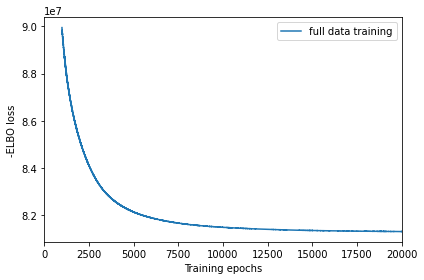

In [63]:
# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [64]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp_mouse_brain.h5ad"
adata_vis.write(adata_file)
adata_file

Sampling global variables, sample: 100%|███████████████████████████████████████████████| 999/999 [00:34<00:00, 29.27it/s]


'./c2l_results/mouse_brain_bin200//cell2location_map/sp_mouse_brain.h5ad'

In [ ]:
#reload 

# adata_file = f"{run_name}/sp_mouse_brain.h5ad"
# adata_vis = sc.read_h5ad(adata_file)
# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

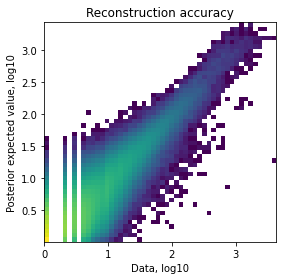

In [65]:
mod.plot_QC()

In [66]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

In [67]:
adata_vis

AnnData object with n_obs × n_vars = 5420 × 12905
    obs: 'array_row', 'array_col', 'sample', '_indices', '_scvi_batch', '_scvi_labels', 'Astro_AMY', 'Astro_AMY_CTX', 'Astro_CTX', 'Astro_HPC', 'Astro_HYPO', 'Astro_STR', 'Astro_THAL_hab', 'Astro_THAL_lat', 'Astro_THAL_med', 'Astro_WM', 'Endo', 'Ext_Amy_1', 'Ext_Amy_2', 'Ext_ClauPyr', 'Ext_Hpc_CA1', 'Ext_Hpc_CA2', 'Ext_Hpc_CA3', 'Ext_Hpc_DG1', 'Ext_Hpc_DG2', 'Ext_L23', 'Ext_L25', 'Ext_L56', 'Ext_L5_1', 'Ext_L5_2', 'Ext_L5_3', 'Ext_L6', 'Ext_L6B', 'Ext_Med', 'Ext_Pir', 'Ext_Thal_1', 'Ext_Thal_2', 'Ext_Unk_1', 'Ext_Unk_2', 'Ext_Unk_3', 'Inh_1', 'Inh_2', 'Inh_3', 'Inh_4', 'Inh_5', 'Inh_6', 'Inh_Lamp5', 'Inh_Meis2_1', 'Inh_Meis2_2', 'Inh_Meis2_3', 'Inh_Meis2_4', 'Inh_Pvalb', 'Inh_Sst', 'Inh_Vip', 'LowQ_1', 'LowQ_2', 'Micro', 'Nb_1', 'Nb_2', 'OPC_1', 'OPC_2', 'Oligo_1', 'Oligo_2', 'Unk_1', 'Unk_2'
    var: 'SYMBOL', 'MT_gene'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'mod'
    obsm: 'spatial', 'MT', 'means_cell_abundance_w_sf', 'stds_cell

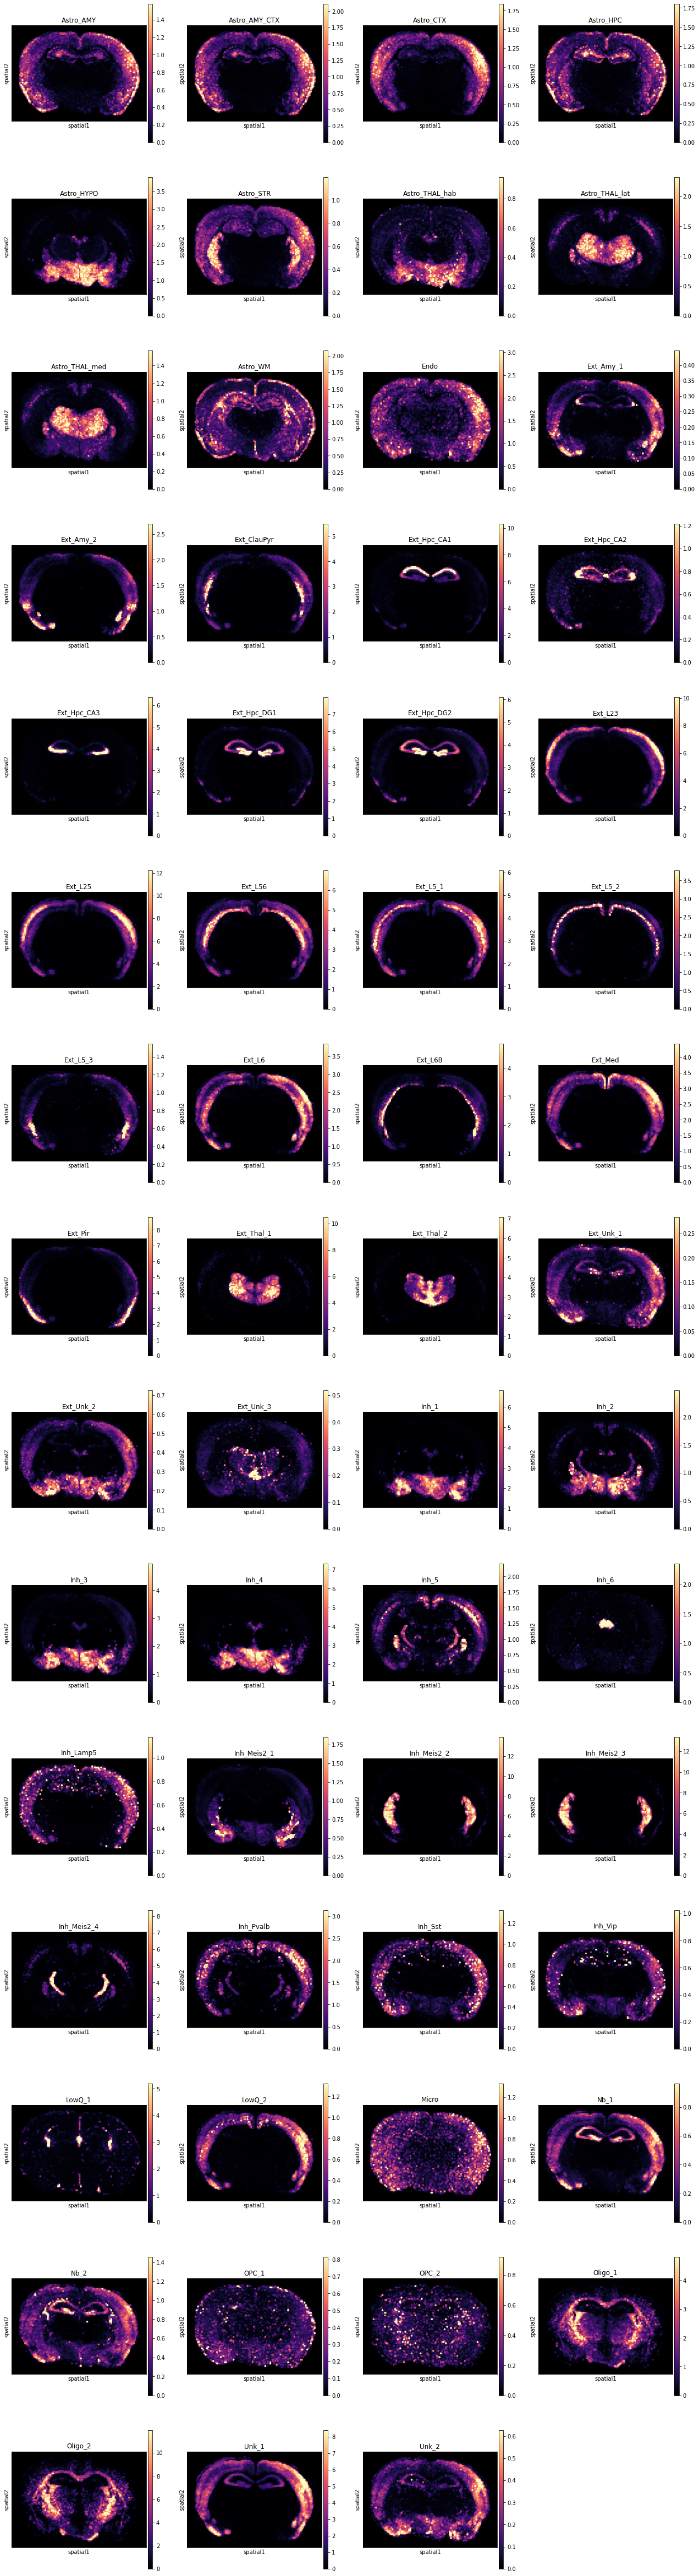

In [68]:
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(adata_vis, cmap='magma',
                  # show first 8 cell types
                  color=['Astro_AMY', 'Astro_AMY_CTX', 'Astro_CTX', 'Astro_HPC', 
                         'Astro_HYPO', 'Astro_STR', 'Astro_THAL_hab', 'Astro_THAL_lat', 
                         'Astro_THAL_med', 'Astro_WM', 'Endo', 'Ext_Amy_1', 
                         'Ext_Amy_2', 'Ext_ClauPyr', 'Ext_Hpc_CA1', 'Ext_Hpc_CA2', 
                         'Ext_Hpc_CA3', 'Ext_Hpc_DG1', 'Ext_Hpc_DG2', 'Ext_L23', 
                         'Ext_L25', 'Ext_L56', 'Ext_L5_1', 'Ext_L5_2', 
                         'Ext_L5_3', 'Ext_L6', 'Ext_L6B', 'Ext_Med', 
                         'Ext_Pir', 'Ext_Thal_1', 'Ext_Thal_2', 'Ext_Unk_1', 
                         'Ext_Unk_2', 'Ext_Unk_3', 'Inh_1', 'Inh_2', 
                         'Inh_3', 'Inh_4', 'Inh_5', 'Inh_6', 
                         'Inh_Lamp5', 'Inh_Meis2_1', 'Inh_Meis2_2', 'Inh_Meis2_3', 
                         'Inh_Meis2_4', 'Inh_Pvalb', 'Inh_Sst', 'Inh_Vip', 
                         'LowQ_1', 'LowQ_2', 'Micro', 'Nb_1', 
                         'Nb_2', 'OPC_1', 'OPC_2', 'Oligo_1', 
                         'Oligo_2', 'Unk_1', 'Unk_2'],
                  ncols=4, spot_size=1.5,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2'
                 )